# Coursework 3: Bilinear Inverse Problems and Low-Rank Matrix Recovery

[x] By tick the checkbox, we hereby declare that this coursework report is our own and autonomous work. We have acknowledged all material and sources used in its preparation, including books, articles, reports, lecture notes, internet software packages, and any other kind of document, electronic or personal communication. This work has not been submitted for any other assessment.

## 3.1 Test Data Generation (10%)

We consider the low-rank matrix completion problem given by 
$$
    \bm{y} = \mathcal{P}_{\Omega}(\bm{X}) 
$$
where $\bm{X} \in \mathbb{R}^{m \times n}$ is a low rank matrix of rank $r$. 

Data generation: Write $\bm{X} = \bm{U} \bm{G} \bm{V}^{\mathsf{T}}$, where $\bm{U} \in \mathbb{R}^{m \times r}$, $\bm{G} \in \mathbb{R}^{r \times r}$, and $\bm{V} \in \mathbb{R}^{n \times r}$ are matrices with i.i.d. $\mathcal{N}(0,1)$ Gaussian entries. (Note that by $\bm{X} = \bm{U} \bm{G} \bm{V}^{\mathsf{T}}$ we are not talking about SVD.)

Design and implement a function `LRMC_data_gen` to generate test data. Provide necessary documentation.

In [1]:
using Random
using LinearAlgebra
using StatsBase
using Distributions
using Plots

function GaussianGen(m::Int64, n::Int64)
    """
    Generates an mxn array using random entries
    sampled from a normal/gaussian distribution.
    Each column in the array is also normalised 
    to be unitary.

    :param m: Int64
        number of rows for returned matrix
    :param n: Int64
        number of columns for returned matrix
    :return: Array{Float64, m, n}
        mxn array with normalised gaussian samples
    """

    A = randn(Float64, m, n)
    Norm = zeros(m,n)

    for i = 1:n
        Norm[:,i] = normalize(A[:,i], 2);
    end

    return Norm
end

function Create_linear_operator(Ω)
    """
    Generates a linear operator matrix A using
    the masking matrix Omega. A is such that the 
    following equations are equal.
    Y = A * X, Y = Ω .* X where .* is element-wise
    multiplication.

    :param Ω: Array{Bool, m, n}
        Masking matrix Ω 
    :return: Array{|Ω|, m*n}
        mxn array with normalised gaussian samples.
    """

    m, n = size(Ω)
    idm = Matrix(1I, m*n, m*n)

    cardinality = count(i->(i != false), vec(Ω))
    A = Array{Int64, 2}(undef, cardinality, m*n)

    idx = 1

    for i = 1:m*n
        if vec(Ω)[i] == true
            A[idx, :] = idm[i, :]
            idx += 1
        end
    end

    return A
end

function Observation_samples(X::AbstractArray, m::Int64, n::Int64, samples::Int64)
    """
    Randomly generates a sampled matrix Y using a 
    matrix X. This is supposed to try and simulate
    how in the real world we might be given a matrix
    Y with missing entries whose ground truth matrix
    is X.

    :param X: Array{Any, m, n}
        Masking matrix Ω.
    :param m: Int64
        Number of rows for X matrix.
    :param n: Int64
        Number of columns for X matrix.
    :param samples: Int64
        Number of random samples (without replacement)
        to retrieve from X to create 'corrupted' matrix Y.
        Corresponds to cardinality of Ω i.e. |Ω|. 
    :return: Array{Any, m, n}, Array{Bool, m, n}
        Returns the sampled ('corrupted') matrix Y as well
        as the matrix Ω which corresponds to the masking
        matrix which was randomly generated to create Y from 
        X.
    """

    random_indices = sample(randperm(m*n), samples, replace=false)

    Ω = zeros(Bool, m, n)
    Ω[random_indices] .= true

    Y = zeros(m, n)

    Y[Ω] = X[Ω]

    return Y, Ω
end

function LRMC_data_gen(m::Int64, n::Int64, r::Int64)
    """
    Creates a matrix with dimensions m, n which will be
    of rank r. Original entries will be sampled from
    N(0, 1) gaussian and then normalised before being
    converted to matrix of rank r.

    :param m: Int64
        Number of rows for generated matrix.
    :param n: Int64
        Number of columns for generated matrix.
    :param r: Int64
        Rank of the generated matrix.
    :return: Array{Float64, m, n}
        The mxn matrix of rank r generated.
    """

    U = GaussianGen(m, r)
    G = GaussianGen(r, r)
    V = GaussianGen(n, r)

    X = U * G * V'

    return X
end

LRMC_data_gen (generic function with 1 method)

## 3.2 Matrix Completion Techniques

In the following, the suggested simulation setup is that $m = 32$, $n=48$, $r$ varies in $2:2:8$, and $|\Omega|/mn$ varies in $\{1/8,~ 1/6,~ 1/4,~ 1/2\}$. 

### 3.2.1 Alternating Minimization (20%)

Design, implement, and run tests for the alternating minimization method for low-rank matrix completion. Use the function name `LRMCRec_AM`. Provide necessary documentation.

For alternating minimization method for low-rank matrix completion, we find the argmin of,
$$
        \frac{1}{2}\underset{P\in\mathbb{R}^{m \times r}, Q\in\mathbb{R}^{n \times r}}{\operatorname{argmin}} \| y - \mathcal{P}_{\Omega}(PQ^{T})\|_{2}^{2}
$$

which then can be defined as,

$$
         \frac{1}{2}\underset{P\in\mathbb{R}^{m \times r}, Q\in\mathbb{R}^{n \times r}}{\operatorname{argmin}} \| y - \mathcal{P}_{\Omega}(\begin{bmatrix}
            p_{1} \\
            p_{2}  \\
            p_{3}  \\
            . \\
            . \\
            . \\
            p_{m} 
        \end{bmatrix} [q_{1} q_{2} q_{3} . . . q_{n}])\|_{2}^{2}
$$

where $ p_{i}$ and $q_{i}$ have a vector length of r.

To update P and Q, it is a simple least square problem where
$$
\frac{1}{2}\|y - PQ^T\|^2_2
$$
which the least square solution would be,

$$
Q^T = pinv(P)*y
$$

then we can update $P$ by transposing the least square problem as shown below,

$$
\frac{1}{2}\|y-PQ^T\|^T
= \|y^T - QP^T\| => \|y^T - QP^T\|^2_2
$$

So for the second least squares problem we solve as such:

$$
P^T = pinv(Q)*y^T
$$

Using these least square solution, we can update P and Q to predict X. 

In [ ]:
using Random
using LinearAlgebra
using StatsBase
using Distributions
using Plots

function Least_squares_P(Y, P, Ω)
    """
    Solves the least squares problem using pseudo-inverse
    with ||y - P*Q'|| for Q. It does so for each column vector
    in Y using the corresp. column vector mask from Ω. Making
    sure that the corresp. revealed entries from y is reflected
    in the resp. rows & columns in P and Q'.

    :param Y: Array{Float64, m, n}
        Our observation matrix which we are using to estimate P and Q.
    :param P: Array{Float64, m, r}
        Our current estimate of P for the Y ≈ P * Q'
    :param Ω: Array{Float64, m, n}
        Masking matrix Ω
    :return: Array{Float64, n, r}
        Least Squares estimation of Q
    """

    r = size(P, 2)
    m = size(Y, 1)
    n = size(Y, 2)
    
    Q = Array{Float64, 2}(undef, n, r)

    for i = 1:n
        y = Y[:, i]
        p = Array{Float64, 2}(undef, m, r)

        for j = 1:r
            p[:, j] = Ω[:, i] .* P[:, j] 
        end

        Q'[:, i] = pinv(p) * y
    end

    return Q
end

function Least_squares_Q(Y, Q, Ω)
    """
    Solves the least squares problem using pseudo-inverse
    with ||y' - Q*P'|| for P. It does so for each column vector
    in Y using the corresp. column vector mask from Ω. Making
    sure that the corresp. revealed entries from y' is reflected
    in the resp. rows & columns in Q and P'.

    :param Y: Array{Float64, m, n}
        Our observation matrix which we are using to estimate P and Q.
    :param Q: Array{Float64, m, r}
        Our current estimate of Q for the Y ≈ P * Q'
    :param Ω: Array{Float64, m, n}
        Masking matrix Ω
    :return: Array{Float64, n, r}
        Least Squares estimation of P
    """

    r = size(Q, 2)
    m = size(Y, 1)
    n = size(Y, 2)

    P = Array{Float64, 2}(undef, m, r)

    for i = 1:m
        y = Y'[:, i]
        q = Array{Float64, 2}(undef, n, r)

        for j = 1:r
            q[:, j] = Ω'[:, i] .* Q[:, j] 
        end

        P'[:, i] = pinv(q) * y
    end

    return P
end

function LRMCRec_AM(Y, Ω, r, iters)
    """
    Low-Rank Matrix Completion using Alternating Minimization.

    :param Y: Array{Float64, m, n}
        Our observation matrix with missing values.
    :param Ω: Array{Float64, m, n}
        Masking matrix Ω.
    :param r: Array{Float64, m, r}
        The rank of our completed matrix. Used to specify columns of P and Q.
    :param iters: Array{Float64, m, r}
        Number of iterations to run for.
    :return: Array{Float64, m, n}
        Our matrix which has had its missing values completed/estimated.
    """

    U, _, _ = svd(Y)

    P = U[:, 1:r]
    Q = Least_squares_P(Y, P, Ω)

    cost_list = []
    cost = norm(Y[Ω] - (P*Q')[Ω], 2)^2
    append!(cost_list, cost)
    
    for i = 1:iters-1
        Q = Least_squares_P(Y, P, Ω)
        P = Least_squares_Q(Y, Q, Ω)

        cost = norm(Y[Ω] - (P*Q')[Ω], 2)^2
        append!(cost_list, cost)
    end

    X = P * Q'
    return X, cost_list
end

In [ ]:
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

log = []

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="AM for r=$(rank)", ylabel="cost", xlabel="iteration")

    for sample_idx = 1:length(samples)
        iters = 100

        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)

        X_predict, cost_list = LRMCRec_AM(Y, Ω, rank, iters)
        error = norm(X_predict - X) / norm(X)

        push!(log, (rank, sample_ratio, error))

        println("Rank: ", rank, " samples: ", Ω_sample, " Error: ", error)
        plot!(plotter, cost_list, label="|Ω|=$(Ω_sample)", fmt = :png, dpi=2080)
    end
    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

### 3.2.2 Iterative Hard Thresholding (IHT) (20%)

Design, implement, and run simple tests for the IHT algorithm for low-rank matrix completion. Use the function name `LRMCRec_IHT`. Provide necessary documentation. 

The IHT algorithm for low-rank matrix recovery is given by
$$
X^{l+1} = H_{rank-r}(X^{l}+τA^{*}(y-A(X^{l})))
$$

where $H_{rank-r} $ is the best rank r approximation given by $\sum_{i=1}^{r} \sigma_{i}u_{i}v_{i}^{T}$ 

The linear map $A$ is the projection operator to a vector of revealed entries only. 

$A(X)$ can be represented in code as $X[Ω]$ within Julia and $y$ can be represented in code as $Y[Ω]$.

$A^{*}$ is the adjoint operator of the linear map $A$ where it maps the projected vector back to a $(m,n)$ matrix. The iterations can hence be represented in code as such : 

            m,n = size(Y)
            temp = zeros(m,n)
            temp[Ω] = Y[Ω] - X[Ω]
            X = rank_r_approx(X + τ*(temp), r)
where the variable 'temp' is equivalent to $A^{*}(y-A(X^{l}))$

In [2]:
function r_rank_approx(M::AbstractArray, r::Int)
    """
    Hard-Thresholding using SVD and the r largest singular values.
    
    :param M: Array{m, n}
        Input matrix of size mxn to perform hard-thresholding on.
    :param r: Int64
        Rank of the matrix we are performing matrix completion on.
    :return: Array{Float64, m, r}
        Matrix which has had hard-thresholding performed on its singular values.
    """

    U, Σ, V = svd(M)
    N = length(Σ)

    for i = r+1:N
        Σ[i] = 0
    end

    return U * Diagonal(Σ) * V'
end

function LRMCRec_IHT(Y, Ω, r::Int, τ::Float64, iters::Int)
    """
    Iterative Hard Thresholding for low-rank-approximation completion problem.
    
    :param Y: Array{Float64, m, n}
        Our observation matrix with missing values.
    :param Ω: Array{Bool, m, n}
        Masking matrix Ω, corresponds to revealed entries in Y.
    :param r: Int64
        Rank of the generated matrix.
    :param τ: Float64
        Step size.
    :param iters: Int
        Number of iterations to run for.
    :return: Array{Float64, m, n}
        Our matrix which has had its missing values completed/estimated.
    """

    m, n = size(Y)
    X = copy(Y)
    
    temp = zeros(m,n)   
    cost_list = []
    cost = norm(Y[Ω] - X[Ω], 2)^2
    append!(cost_list, cost)

    for i = 1:iters
        # Iteration algorithm to reduce objective error 
        temp[Ω] = Y[Ω] - X[Ω]
        X = r_rank_approx(X + τ*(temp), r)
        
        #Calculate current cost
        cost = norm(Y[Ω] - X[Ω], 2)^2
        append!(cost_list, cost)

    end 
    return X, cost_list
end

LRMCRec_IHT (generic function with 1 method)

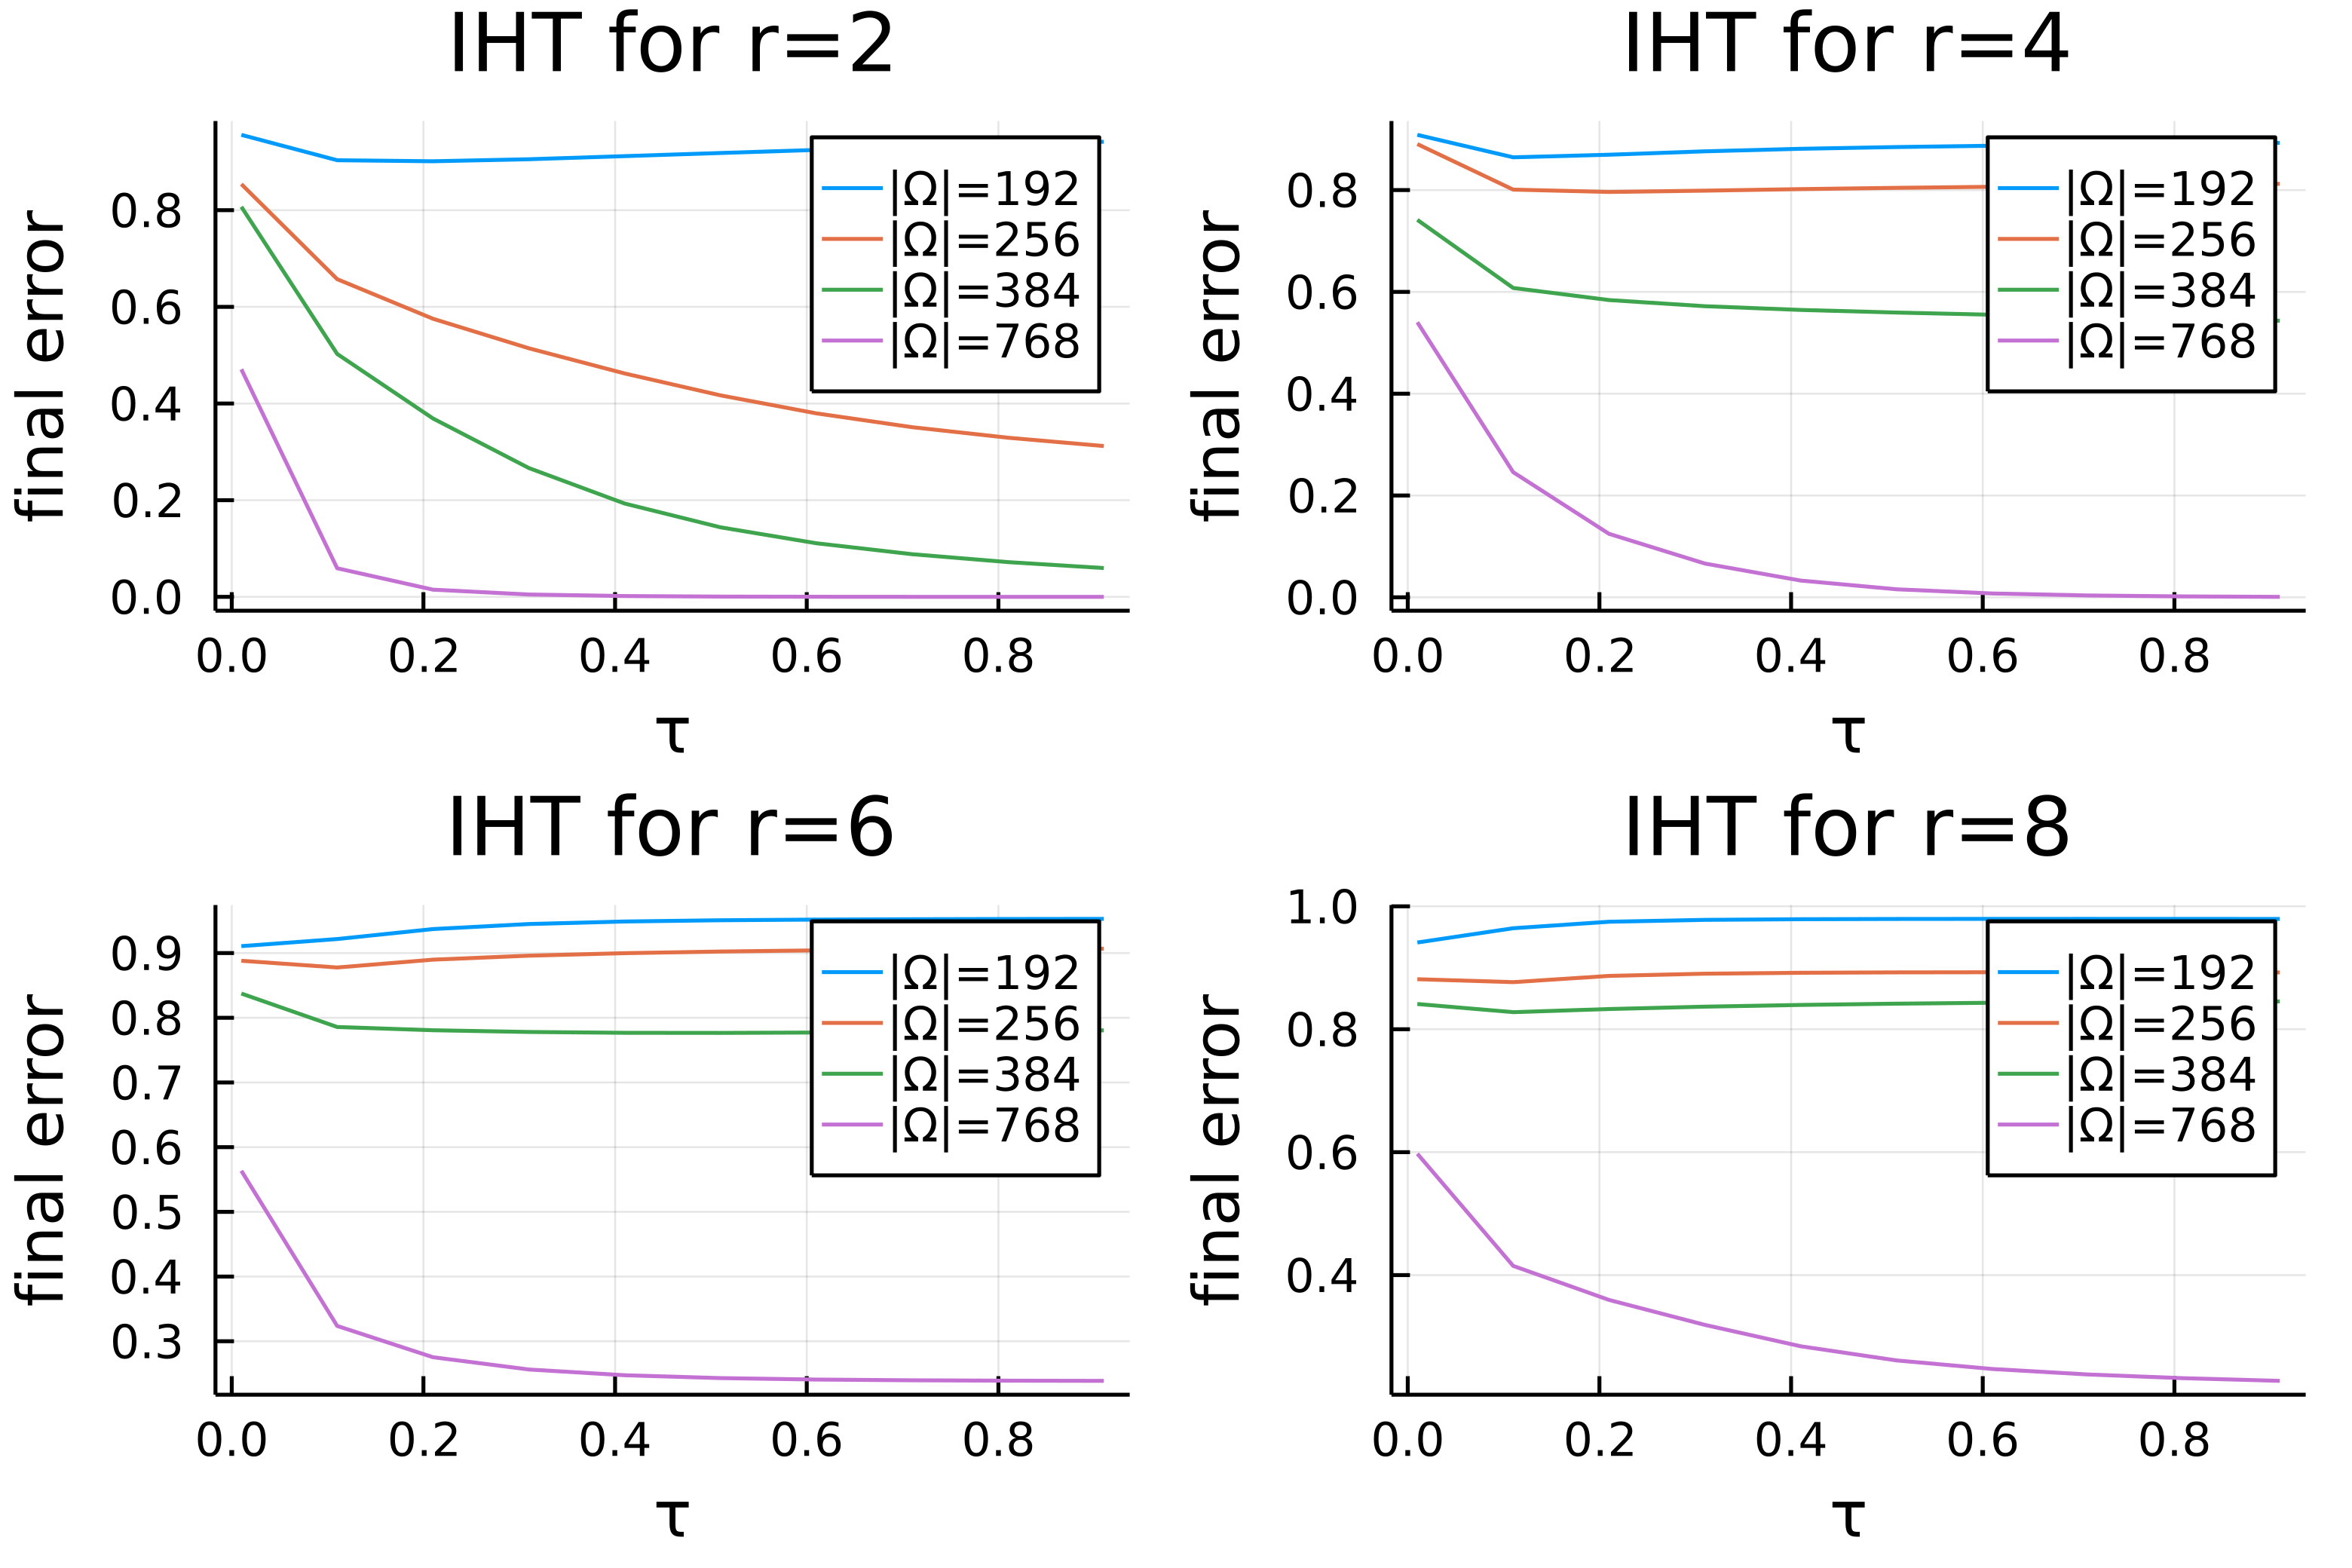

In [3]:
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

log = []

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="IHT for r=$(rank)", ylabel="final error", xlabel="τ")

    for sample_idx = 1:length(samples)

        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)
        info_τ = []
        info_error = []

        for τ = 0.01:0.1:1.0
            iters = 100
            X_predict, _ = LRMCRec_IHT(Y, Ω, rank, τ, iters)
            error = norm(X_predict - X) / norm(X)

            push!(info_τ, τ)
            push!(info_error, error)

            push!(log, (rank, sample_ratio, τ, error))
        end

        plot!(plotter, info_τ, info_error, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=520)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

When finding the best low rank approximation of $X$, $\hat{X}$ with rank($\hat{X}$) = rank($X$) gives the best approximation of $X$.

In general, the two following points hold true.



* For a matrix with fixed-size, a larger number of revealed entries results in a lower final error between $\hat{X}$ and $X$
* For a matrix with fixed-size, a lower rank of $X$ will result in a lower final error between $\hat{X}$ and $X$
* For a matrix with a higher rank, we require a sufficiently larger amount of revealed entries such that the final error can be significantly reduced.






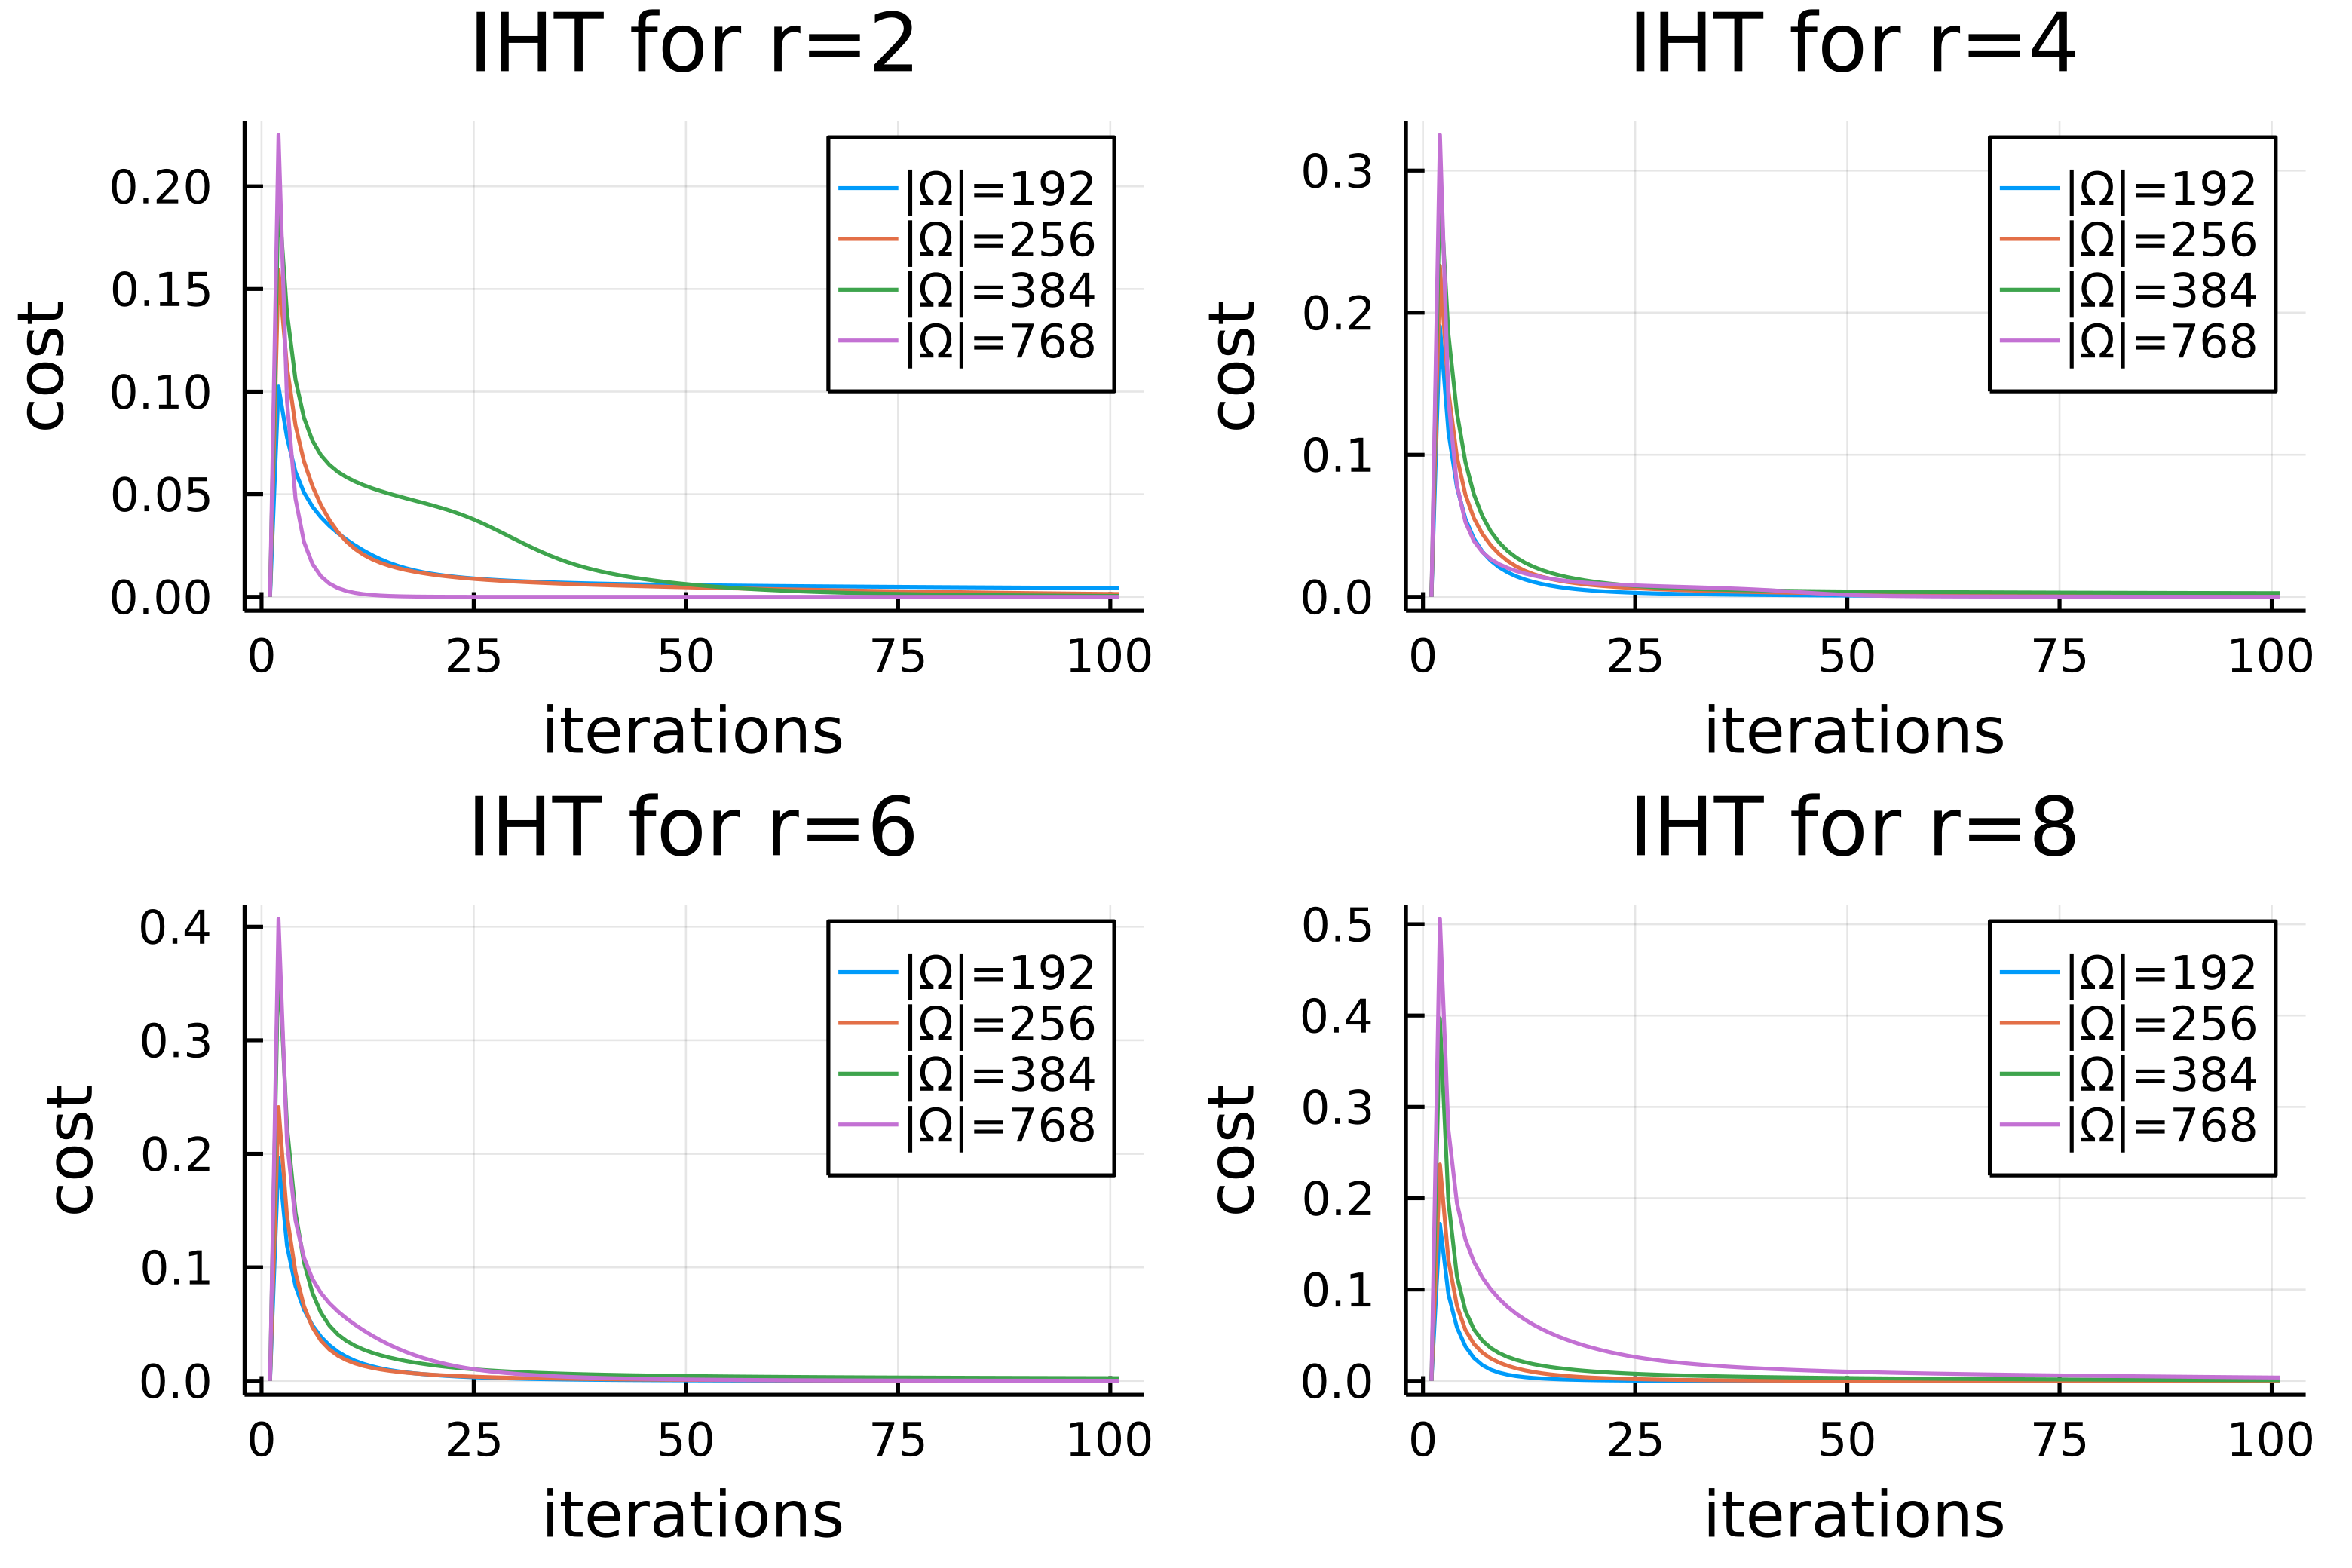

In [4]:
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="IHT for r=$(rank)", ylabel="cost", xlabel="iterations")

    for sample_idx = 1:length(samples)
        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)

        τ = 1.0
        iters = 100
        X_predict, cost_list = LRMCRec_IHT(Y, Ω, rank, τ, iters)
        error = norm(X_predict - X) / norm(X)

        plot!(plotter, cost_list, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=520)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

The cost function converges to a sufficiently small value in all cases regardless of the rank of $X$ and the number of revealed entries |Ω|

### 3.2.3 Iterative Shrinkage-Thresholding Algorithm (ISTA) (25%)

Design, implement, and run simple tests for ISTA (to solve the Lasso formulation) for low-rank matrix completion. Use the function name `LRMCRec_ISTA`. Provide necessary documentation. Use simulations to discuss the choice of parameters.

For Iterative Shrinkage-Thresholding Algorithm for low rank matrix completion, we start with the lasso formulation,
$$
        \frac{1}{2}\|y - \mathbb{A}(X)\|^2_2 + \lambda\|X\|_{tr}
$$
Where the $\|X\|_{tr}$ is the nuclear norm of X which is,

$$
        \|X\|_{tr} = \sum_{(i,j) \in \Omega}^r\sigma_i(B)
$$

$$
            \partial \|X\|_{tr} = \sum_{i = 1}^{min(m,n)} sign(\sigma_i)u_iv_i^T    
$$

The proximal operator of the nuclear norm is,
$$
\underset{X}{\operatorname{argmin}}\|X\|_{tr} + \frac{1}{2\gamma}\|X-Z\|^2_F
$$
$$
=\sum_{i = 1}^{min(m,n)}\eta(\sigma_i;\gamma)u_iv_i^T
$$

Let $f(X) = \frac{1}{2}\|y - \mathbb{A}(X)\|^2_2 $.
This can be used if we approximate the objective function as,
$$
f(X) + \lambda\|X\|_{tr}
\approx f(X^l) + <X-X^l,\nabla f(X^l)> + \frac{1}{2\tau^l}\|X-X^l\|^2_2 + \lambda\|X\|_{tr}
$$
$$
= \frac{1}{2\tau^l}\|X-(X^l - \tau^l\nabla f(X^l))\|^2_2 + \lambda\|X\|_{tr} + c
$$
This is very similar to the soft thresholding function given above for the proximal operator of the nuclear norm. Therefore the iteration is given by,
$$
X^{l+1} = \eta_{\sigma}(X^l + \tau^l\mathbb{A}^*(y-\mathbb{A}(X^l));\lambda\tau^l)
$$

Since the linear operator for our case is $\mathcal{P}_{\Omega}(\bm{X})$, the iteration will be as shown,

$$
X^{l+1} = S_{\lambda\tau}(X+t(\mathcal{P}_{\Omega}(Y)-\mathcal{P}_{\Omega}(X)))
$$

Therefore, we can use this soft thresholding function to update our X for each iteration in the code.

In [ ]:
using Random
using LinearAlgebra
using StatsBase
using Distributions
using Plots

# Helper functions

function nuclear_norm(X)
    """
    Computes the nuclear norm of X using the singular values.
    
    :param X: Array{Float64, m, n}
        Input matrix to compute nuclear norm on.
    :return: Float64
        Nuclear norm of X
    """

    _, S, _ = svd(X)
    return sum(S)
end

function current_cost(X, Y, Ω, λ)
    """
    Computes the Cost function (Lasso) for X and Y.
    
    :param X: Array{Float64, m, n}
        Input matrix meant to symbolise the matrix we've predicted.
    :param Y: Array{Float64, m, n}
        Input matrix meant to symbolise the matrix we're trying to recreate.
    :param Ω: Array{Bool, m, n}
        Masking matrix Ω, corresponds to revealed entries in Y.
    :param λ: Float64
        Integer value for the regularization parameter in Lasso.
    :return: Float64
        Cost i.e. (1/2) * ||Pr(Y) - Pr(X)||_2 + λ||Pr(X)||_*
    """
    
    return 0.5 * norm(X[Ω] - Y[Ω])^2 + λ * nuclear_norm(X)
end

function Singular_value_soft_threshold(X, λ)
    """
    Computes the Soft-Threshold on the singular values of X using 
    regulariation parameter λ.
    
    :param X: Array{Float64, m, n}
        Input matrix to compute on.
    :param λ: Float64
        Integer value for the regularization parameter in Lasso.
    :return: Array{Float64, m, n}
        Matrix which has had Soft-Thresholding 
        applied on its singular values.
    """

    U, S, V = svd(X)
    threshold = max.(S .- λ, 0.0)
    return U * Diagonal(threshold) * V'
end

# Low Rank Matrix Completion Iterative Shrinkage Thresholding Algorithm.

function LRMCRec_ISTA(Y, Ω, λ, iterations)
    """
    Computes the Iterative-Soft-Thresholding-Algorithm for the purpose
    of Low Rank Matrix Completion for a observation matrix Y. Uses Lasso 
    in order to create sparse solutions.
    
    :param Y: Array{Float64, m, n}
        Our observation matrix with missing values.
    :param Ω: Array{Bool, m, n}
        Masking matrix Ω, corresponds to revealed entries in Y from
        some ground-truth matrix we don't know.
    :param λ: Float64
        Regularization parameter
    :param iters: Int
        Number of iterations to run for.
    :return: Array{Float64, m, n}
        Our matrix which has had its missing values completed/estimated.
    """

    X = copy(Y)

    cost_list = zeros(iterations + 1)
    cost_list[1] = current_cost(X, Y, Ω, λ)

    for i=1:iterations
        X[Ω] = Y[Ω]
        X = Singular_value_soft_threshold(X, λ)

        cost_list[i+1] = current_cost(X, Y, Ω, λ)
    end

    return X, cost_list
end

In [ ]:
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

log = []

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="ISTA for r=$(rank)", ylabel="final error", xlabel="λ")

    for sample_idx = 1:length(samples)

        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)
        info_λ = []
        info_error = []

        for λ = 0.01:0.1:1.0
            iters = 100
            X_predict, cost_list = LRMCRec_ISTA(Y, Ω, λ, iters)
            error = norm(X_predict - X) / norm(X)

            push!(info_λ, λ)
            push!(info_error, error)

            push!(log, (rank, sample_ratio, λ, error))
        end

        plot!(plotter, info_λ, info_error, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=2080)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])


In [ ]:
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="ISTA for r=$(rank)", ylabel="cost", xlabel="iterations")

    for sample_idx = 1:length(samples)
        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)

        λ = 0.01
        iters = 100
        X_predict, cost_list = LRMCRec_ISTA(Y, Ω, λ, iters)
        error = norm(X_predict - X) / norm(X)

        plot!(plotter, cost_list, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=2080)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

### 3.2.4 Lasso-ADMM (25%)

Design, implement, and run simple tests for an ADMM algorithm (to solve the Lasso formulation) for low-rank matrix completion. Use the function name `LRMCRec_ADMM`. Provide necessary documentation. Compare ADMM and ISTA in terms of convergence.

Lasso formulation is written as:
$$
argmin_{x} \frac{1}{2}||y - Ax||_{2}^{2} + \lambda||x||_{1}
$$
Since ADMM algorithm will be used for low rank matrix completion, we can interpret the $Ax$ of the lasso problem as the linear mapping of the revealed entries of x (our estimation matrix) indexed by $\Omega$.

Given that the corresponding ADMM iterations are:
$$
x^{k+1} = arg min_x \frac{1}{2}||y - Ax||_{2}^{2} + \frac{\rho}{2}||x - z_{k} + \frac{v_{k}}{\rho}||_{2}^{2}
$$
$$
z^{k+1} = arg min_z \lambda ||z||_{1} + \frac{\rho}{2}||x_{k+1} - z + \frac{v_{k}}{\rho}||_{2}^{2}
$$
$$
v^{k+1} = v_{k} + \rho (x^{k+1} - z^{k+1})
$$

For $x^{k+1}$, we can calculate the closed form solutions by setting $\nabla f(x)=0$, resulting in:
$$
x = (A^{T}A + \rho)^{-1} (A^{T}y + \rho z^{k} - v^{k})
$$

Here $(A^{T}A + \rho)^{-1}$ is equal to the reciprocal of $A^{T}A + \rho$, i.e $\frac{1}{element}$, as it is a diagonal matrix. $A^{T} y = Y$ so it results in element wise division by each corresponding element in $\Omega + \rho$ where $\Omega$ is our matrix of revealed entries.
Thus, we have:
$$
x^{k+1} = (Y + \rho*(Z-V))⊙(\Omega + \rho)
$$
where ⊙ is element-wise division

To find the closed form solution of $z^{k+1}$, we first consider the solution for the ISTA algorithm. 

$$
X^{*} = arg min_{x}||X|| + \frac{1}{2\gamma}||X-Z||^{2}_{F}
$$
$$
= \Sigma_{i=1}\eta(\sigma_{i};\gamma)u_{i}v_{i}^{T} 
$$
where $\eta$ is the soft thresholding function.
Comparing this to the iterations of $z^{k+1}$, we see that it is of similar form and thus can compose:
$$
z^{k+1} = \eta(X+V; \frac{\lambda}{\rho})
$$

In [ ]:
# Helper functions

function Singular_value_soft_threshold(X, λ)
    """
    Generates a matrix which has had Soft-Thresholding calculated
    on its singular values using SVD.

    :param X: Array{Float64, m, n}
        Matrix to calculate singular value soft thresholding on.
    :param λ: Float64
        Regularization parameter.
    :return: Array{Float64, m, n}
        Matrix which has had soft-threshold applied on its singular
        value.
    """

    U, S, V = svd(X)
    threshold = max.(S .- λ, 0.0)
    return U * Diagonal(threshold) * V'
end


function nuclear_norm(X)
    """
    Calculates the L1/Nuclear norm of a matrix

    :param X: Array{Float64, m, n}
        Input Matrix to compute nuclear norm of.
    :return: Float64
        Nuclear norm of Matrix X
    """

    _, S, _ = svd(X)
    return sum(S)
end


function current_cost(X, Y, Ω, λ)
    """
    Calculates the lasso formulation

    :param X: Array{Float64, m, n}
        our estimated matrix that we try to complete.
    :param Y: Array{Float64, m, n}
        the groundtruth masked matrix.
    :param Ω: Array{Float64, m, n}
        Matrix of revealed indices in Y.
    :param λ: Float64
        Regularization parameter for the lasso problem.
    :return: Float64
        Cost i.e. (1/2) * ||Pr(Y) - Pr(X)||_2 + λ||Pr(X)||_*
            
    """

    return 0.5 * norm(X[Ω] - Y[Ω])^2 + λ * nuclear_norm(X)
end

function LRMCRec_ADMM(Y, Ω, λ, ρ, iters, error_diff_tresh)
    """
    Solve the lasso problem for low rank matrix completion with the ADMM algorithm.

    :param Y: Array{Float64, m, n}
        Our observation matrix with missing entries
    :param Ω: Array{Bool, m, n}
        Matrix of revealed entries from Y.
    :param λ: Float64
        Regularization parameter for the lasso problem.
    :param ρ: Float64
        Penalty parameter for the ADMM algorithm.
    :param iters: Int64
        Maximum number of iterations for the algorithm before breaking
    :param error_diff_tresh: Float64
        Threshold comparing the current loss and previous loss to determine whether a significant update has been made.
    :return: Array{Float64, m, n}
        The matrix which we got using low rank matrix completion with the ADMM algorithm for Lasso problems.
    """

    X = copy(Y)
    m, n = size(X)
    
    Z = zeros(Float64, m, n)
    V = zeros(Float64, m, n)

    cost_past = Inf
    cost = current_cost(X, Y, Ω, λ)
    counter = 0
    cost_list = []
    push!(cost_list, cost)
    
    while counter <= iters
        X = (Y + ρ*(Z - V)) ./ (Ω .+ ρ)
        Z = Singular_value_soft_threshold(X+V, λ/ρ)
        V += X
        V -= Z

        cost = current_cost(X, Y, Ω, λ)
        push!(cost_list, cost)
        counter += 1

        if (cost_past - cost <= error_diff_tresh)
            break
        else
            cost_past = cost
        end
    end

    return X, counter, cost_list
end

In [ ]:
#Testing lambda vs Final Error

using Plots
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

log = []

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="ADMM for r=$(rank)", ylabel="final error", xlabel="λ")

    for sample_idx = 1:length(samples)

        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)
        info_λ = []
        info_error = []

        for λ = 0.01:0.01:0.25
            iters = 100
            ρ = 0.5
            error_diff_thresh = 0.00001
            X_predict, counter, cost_list = LRMCRec_ADMM(Y, Ω, λ, ρ, iters, error_diff_thresh)
            error = norm(X_predict - X) / norm(X)

            push!(info_λ, λ)
            push!(info_error, error)

            push!(log, (rank, sample_ratio, λ, error))
        end

        plot!(plotter, info_λ, info_error, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=2080)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

When comparing the error versus $\lambda$, the plots reveal the minimum error occurs approximately around and before 0.05 across the various ranks. We use this as a guideline to determine our $\lambda$ value.

In [ ]:
#Testing error vs rho

m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

log = []

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="ADMM for r=$(rank)", ylabel="final error", xlabel="ρ")

    for sample_idx = 1:length(samples)

        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)
        info_ρ = []
        info_error = []

        for ρ = 0.01:0.01:1
            iters = 100
            λ = 0.025
            error_diff_thresh = 0.00001
            X_predict, counter, cost_list = LRMCRec_ADMM(Y, Ω, λ, ρ, iters, error_diff_thresh)
            error = norm(X_predict - X) / norm(X)

            push!(info_ρ, ρ)
            push!(info_error, error)

            push!(log, (rank, sample_ratio, ρ, error))
        end

        plot!(plotter, info_ρ, info_error, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=2080)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

Comparing the final error to $\rho$, the plots reveal that there is no definite relationship between the two variables as the final error is approximately uniform, independent of $\rho$. $\rho$ is an arbitrary penalty constant, which is as expected.

In [ ]:
#Testing performance of the ADMM algorithm
m, n = 32, 48

samples = [1/8, 1/6, 1/4, 1/2]

plot_arr = Plots.Plot{Plots.GRBackend}[]

for rank = 2:2:8
    X  = LRMC_data_gen(m, n, rank)
    plotter = plot(title="ADMM for r=$(rank)", ylabel="cost", xlabel="iterations")

    for sample_idx = 1:length(samples)
        sample_ratio = samples[sample_idx]
        Ω_sample = Int(m*n * sample_ratio)

        Y, Ω = Observation_samples(X, m, n, Ω_sample)

        λ = 0.025
        ρ = 1
        error_diff_thresh = 0.00001
        iters = 100
        X_predict, counter, cost_list = LRMCRec_ADMM(Y, Ω, λ, ρ, iters, error_diff_thresh)

        plot!(plotter, cost_list, label="|Ω|=$(Ω_sample)",fmt = :png, dpi=2080)
        ln = length(cost_list)
    end

    push!(plot_arr, plotter)
end

plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4])

The ADMM algorithm performs a sharp convergence for all of the various ranks and omega values. For each rank and omega, the cost approximately converges in less than 25 iterations. 

Comparedd to the performance to the ISTA algorithm, the ADMM demonstrates superior performance with a quicker convergence across all ranks and cardinalities. For example, at rank = 8 and cardinality = 768, the ADMM algorithm converges at approximately 50 iterations. The ISTA algorithm converges at approximately 100 iterations.

Compared to the ISTA algorithm, the ADMM demonstrates a sharper, or quicker, convergence, most likely due to the dual ascent approach stemming from the Lagrangian multipliers, not found in the ISTA algorithm.

## Highlight

Please list a couple of highlights of your coursework that may impress your markers.

1. Our functions are all documented like you would find in the standard libary of Python and many other popular Python projects you might find on GitHub.
2. By using a masking matrix Ω instead of a Linear Operator 'A', we speed up our calculations quite a bit. It also enables us to write very simple code calculations in comparison to if we had used 'A'. It took considerable work to translate the algorithms to a code friendly format.
3. We also give short mathematical explanations to have we arrived at the code written from the definitions from the lecture notes.
4. We learned where we could remove extraneous constants, such as τ from ISTA (the step-size) doesn't matter too much since it is essentially fixed. Instead it can be 'clumped' together with λ for ISTA.
5. Our plots are concise, labeled with Legend and Axes, as well as show good detailed results.